In [1]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
import numpy as np
from typing import Tuple
from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.laplacian_pyramid import bpp

<figure id="figure-5">
<div style="background-color: white">

![](figures/dwt.svg)
</div>

<figcaption style="text-align: center">

Figure 5: An $L$ level binary discrete wavelet transform.</figcaption></figure>

# 9 The Discrete Wavelet Transform (DWT)

<div class="alert alert-warning alert-block">
    
This notebook is incomplete!</div>

The final method of energy compaction that we shall investigate, is the
discrete wavelet transform. In some ways this attempts to combine the best features of
the Laplacian pyramid and the DCT:

* Like the pyramid, the DWT analyses the image at a range of different
  scales (levels) and employs symmetrical filters;

* Like the DCT, the DWT avoids any expansion in the number of coefficients.

Wavelet theory was evolved by mathematicians during the 1980's. As with the LBT, we shall not attempt to teach this theory here, just illustrate a relatively simple form of it.

Wavelets are short waveforms which are usually the impulse responses of
filters.  Wavelet transforms employ banks of bandpass filters, whose impulse
responses are scaled versions of each other, in
order to get pass-bands in different parts of the frequency spectrum.  If the
impulse response of a filter is scaled in time by a factor $a$, then the
filter frequency response is scaled by the factor $1/a$.  Typically $a = 2$
from one filter to the next, and each bandpass filter is designed to pass a
2:1 range of frequencies (one octave). We can split an image up using wavelets by a process known as a _binary wavelet tree_.

## 9.1 The binary wavelet tree


We start in 1-D with the
simplest possible pair of filters, operating on just two input samples, $x_n$
and $x_{n-1}$.  The two filter outputs, $u_n$ and $v_n$ at time $n$ are
given by:
$$
 u_n = \tfrac{1}{2} (x_n + x_{n-1}) \quad \text{and} \quad
 v_n = \tfrac{1}{2} (x_n - x_{n-1})
$$

The first filter averages adjacent samples, and so rejects the higher
frequency components of $x$, while the second filter differences these
samples, and so rejects the lower frequency components.  These filters are
known as the _analysis_ filter pair, $H_1(z) = \tfrac{1}{2} (1 + z^{-1})$
and $H_2(z) = \tfrac{1}{2} (1 - z^{-1})$.  It is clear that we can recover the
two input samples from the filter outputs using:
$$
 x_n = u_n + v_n \quad \text{and} \quad x_{n-1} = u_n - v_n
$$

Next it is important to note that we need only retain the samples of $u_n$
and $v_n$ at even values of $n$ in order to be able to recover all the
original samples of $x$.  Hence $u$ and $v$ may be decimated 2:1 and still
allow perfect reconstruction of $x$.  If $x$ is a finite length vector (e.g. a
row of image pixels), then $u$ and $v$ are each half as long as $x$, so the
total number of samples is preserved by the transformation.

A wavelet binary tree may be constructed using these filters, by using an
identical pair, $H_1$ and $H_2$, to filter the decimated lowpass signal
$u_{2n}$, to give a pair of outputs, $uu_{2n}$ and $uv_{2n}$, representing
the lower and upper halves of the first low band.  These may again be
decimated 2:1 and still permit perfect reconstruction of $u$.  This process
may be continued as often as desired: each time splitting the lowest band in
two, and decimating the sample rate of the filter outputs by 2:1.  At each
stage the bandwidth of the two lowest filters is halved, and their impulse
responses are doubled in length.  The total number of output samples remains
constant, however many stages are used.

For example, if $f_s$ is the input sample rate, a 3-stage binary tree will
split the input signal bandwidth of 0 to $f_s/2$ into the following four
bands:
$$
0 \rightarrow f_s/16; \ \ f_s/16 \rightarrow f_s/8; \ \ f_s/8 \rightarrow
f_s/4;  \ \ f_s/4 \rightarrow f_s/2.
$$

The very simple filters, given above, do not generate a filter tree with
good characteristics, since the wavelets turn out to be just a pair of
square pulses.  These generate _blocking_ artefacts when used for image
compression (in fact they are equivalent to the 2 point ($N=2$)
DCT). A better set of filters are the LeGall 5 and 3 tap pair,
given by:
$$
 u_n = \tfrac{1}{8} (-x_{n+2} + 2 x_{n+1} + 6 x_n + 2 x_{n-1} - x_{n-2})
  \quad \text{ and }  \quad
 v_{n+1} = \tfrac{1}{4} (-x_{n+2} + 2 x_{n+1} - x_n)
$$

If $u$ and $v$ are decimated by 2 by choosing even $n$ only, the lowband outputs
$u_n$ are centred on the even samples, and the highband outputs $v_{n+1}$ are
centred on the odd samples.  This is very important to allow perfect
reconstruction of $x$ from $u$ and $v$.

The equations for reconstruction may be obtained by solving the above to get:

\begin{align}
 x_n &= \tfrac{1}{2} (-v_{n+1} + 2 u_n - v_{n-1}) \quad \text{and}  \\
 x_{n+1} &= \tfrac{1}{2} (x_{n+2} + 4 v_{n+1} + x_n) =
 \tfrac{1}{4} (-v_{n+3} + 2 u_{n+2} + 6 v_{n+1} + 2 u_n - v_{n-1})
\end{align}

In general, most analysis filters will not yield such simple reconstruction
solutions, and the design of suitable filters is a non-trivial topic that we
shall not cover here.


# 9.2 Applying the DWT to images


As with the DCT, the 2-D DWT may be obtained by applying a 1-D transform to
first the rows and then the columns of an image.

Start by loading the Lighthouse image and defining the two LeGall
filters given above:

In [2]:
X, _ = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0
h1 = np.array([-1, 2, 6, 2, -1])/8
h2 = np.array([-1, 2, -1])/4

We can use the function `rowdec` from the pyramid work, to
produce a decimated and lowpass filtered version of the rows of
`X` (remembering to subtract 128 as before) using:

In [3]:
from cued_sf2_lab.laplacian_pyramid import rowdec
U = rowdec(X, h1)

To get the high-pass image `V`, it is important to align the decimated
samples with the odd columns of `X` (assuming the first column is $n = 0$)
whereas `U` is aligned with the even columns.  To do this we use a
slightly modified version of `rowdec`, called `rowdec2`.

In [4]:
from cued_sf2_lab.laplacian_pyramid import rowdec2
V = rowdec2(X, h2)

<div class="alert alert-block alert-danger">

Display `U` and `V` to see the outputs of the first filter pair
and comment on their relative energies (or standard deviations). Note that `U` and `V` are half the width of `X`, but that `U` is otherwise similar to `X`.</div>

(256, 128)
(256, 128)
Relative energy of U = 82309592.40625
Relative energy of V = 3501848.25


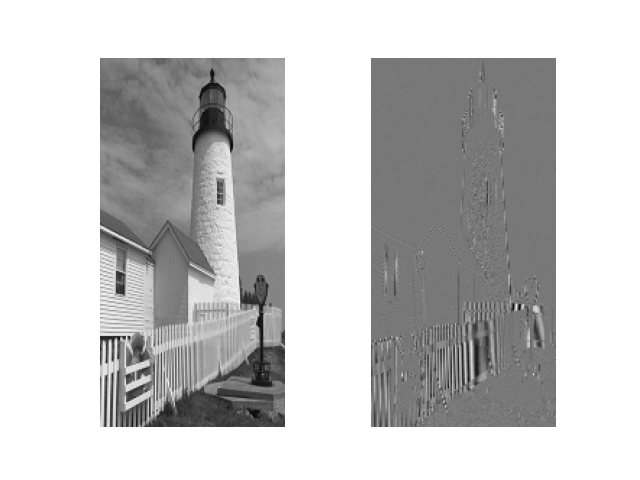

In [5]:
# your code here
print(U.shape)
print(V.shape)
print(f'Relative energy of U = {np.sum(U**2)}')
print(f'Relative energy of V = {np.sum(V**2)}')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(U, cmap='gray')
ax[1].imshow(V, cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

Now filter the columns of `U` and `V` using `rowdec
/ rowdec2` with the transpose operator:

In [6]:
UU = rowdec(U.T, h1).T
UV = rowdec2(U.T, h2).T
VU = rowdec(V.T, h1).T
VV = rowdec2(V.T, h2).T

<div class="alert alert-block alert-danger">
    
Display `np.block([[UU, VU], [UV, VV]])`, and comment
on what sort of edges or features are selected by each filter. You may need to multiply the high-pass images by a factor $k > 1$ to display them clearly. Why is this?</div>

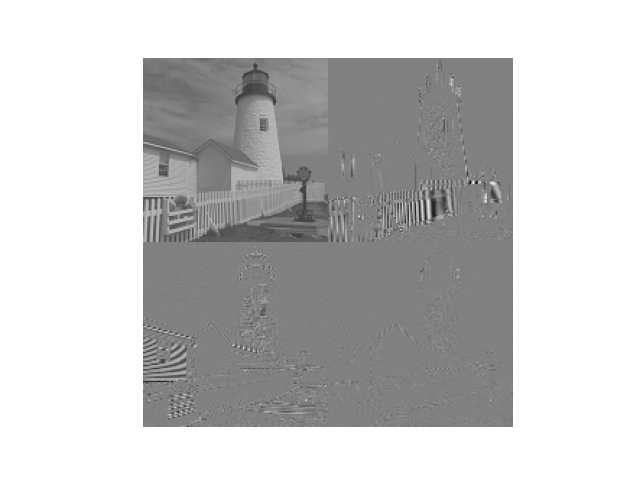

In [7]:
# your code here
k = 3
fig, ax = plt.subplots()
ax.imshow(np.block([[UU, VU*k], [UV*k, VV*k]]), cmap='gray')
ax.axis('off')
plt.show()


We must now check that it is possible to recover the image from
these sub-images, using reconstruction filters, `g1` and `g2`, and the functions, `rowint` and `rowint` (which
is modified in a similar way to `rowdec2` to allow correct
alignment of the high-pass samples). To reconstruct `Ur` and
`Vr` from `UU`, `UV`, `VU` and `VV` use:

In [8]:
from cued_sf2_lab.laplacian_pyramid import rowint, rowint2

g1 = np.array([1, 2, 1])/2
g2 = np.array([-1, -2, 6, -2, -1])/4
Ur = rowint(UU.T, g1).T + rowint2(UV.T, g2).T
Vr = rowint(VU.T, g1).T + rowint2(VV.T, g2).T

Note the gain of 2 in the reconstruction filters, `g1` and
`g2` (to compensate for losing half the samples in the
decimation / interpolation processes).   These filters are also
not quite the same as those that might be inferred from the
equations for $x_n$ and $x_{n+1}$ on the previous page.  This is
because `g1` defines how {\it only} the $u$ samples contribute
both to the even and odd samples of $x$, while `g2` defines
how the $v$ samples contribute.

Check that `Ur` and `Vr` are the same as `U` and
`V`, and then reconstruct `Xr` from these:

In [9]:
# your code here to check Ur and Vr
print(np.max(np.abs(Ur - U)))
print(np.max(np.abs(Vr - V)))

0.0
0.0


In [10]:
# demonstrator answer here
np.testing.assert_equal(Ur, U)
np.testing.assert_equal(Vr, V)

In [11]:
Xr = rowint(Ur,g1) + rowint2(Vr,g2)

Check that `Xr` is the same as `X`.

In [12]:
# your code here
np.testing.assert_equal(Xr, X)

The above operations are a bit tedious to repeat if we want to
apply the DWT recursively to obtain several levels of filtering,
so we have written a pair of functions, `dwt` and `idwt`, to perform the 2-D analysis and reconstruction
operations. Examine these to see that they perform the same
operations as above, except that the transformed sub-images are
stored as parts of a single matrix, the same size as `X`,
rather than as separate matrices.

In [13]:
from cued_sf2_lab.dwt import dwt
IPython.display.Code(inspect.getsource(dwt), language="python")

def dwt(X: np.ndarray, h1: np.ndarray = h1, h2: np.ndarray = h2) -> np.ndarray:
    """
    Return a 1-level 2-D discrete wavelet transform of X.

    Default h1 and h2 are the LeGall filter pair.

    Parameters:
        X: Image matrix (Usually 256x256)
        h1, h2: Filter coefficients
    Returns:
        Y: 1-level 2D DWT of X
    """
    m, n = X.shape
    if m % 2 or n % 2:
        raise ValueError("Image dimensions must be even")
    Y = np.concatenate([rowdec(X, h1), rowdec2(X, h2)], axis=1)
    Y = np.concatenate([rowdec(Y.T, h1).T, rowdec2(Y.T, h2).T], axis=0)
    return Y

In [14]:
from cued_sf2_lab.dwt import idwt
IPython.display.Code(inspect.getsource(idwt), language="python")

def idwt(X: np.ndarray, g1: np.ndarray = g1, g2: np.ndarray = g2)-> np.ndarray:
    """
    Return a 1-level 2-D inverse discrete wavelet transform on X.

    If filters G1 and G2 are given, then they are used, otherwise the LeGall
    filter pair are used.
    """
    m, n = X.shape
    if m % 2 or n % 2:
        raise ValueError("Image dimensions must be even")
    m2 = m//2
    n2 = n//2
    Y = rowint(X[:m2, :].T, g1).T + rowint2(X[m2:, :].T,g2).T;
    Y = rowint(Y[:, :n2], g1) + rowint2(Y[:, n2:], g2)
    return Y

You can check their operation as below::

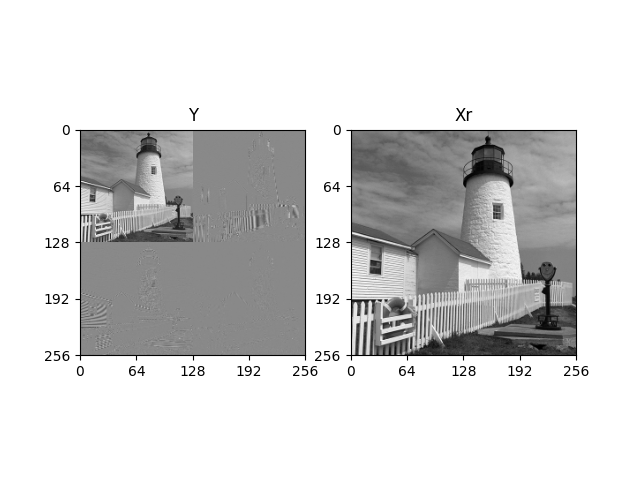

In [15]:
Y = dwt(X)
Xr = idwt(Y)

fig, axs = plt.subplots(1, 2)
plot_image(Y, ax=axs[0])
axs[0].set(title="Y")
plot_image(Xr, ax=axs[1])
axs[1].set(title="Xr");

`Y` should be the same as the composite `[UU VU; UV VV]` image that
you displayed earlier, and `Xr` should be the same as `X`.

Now implement a multilevel DWT by first applying `dwt` to
`X` using:

```python
m=256
Y=dwt(X)
plot_image(Y, ax=some_axis)
```

and then iteratively apply `dwt` to the top left sub-image
of `Y` by repeating:
```python
m = m//2
Y[:m,:m] = dwt(Y[:m,:m])
plot_image(Y, ax=some_axis)
```

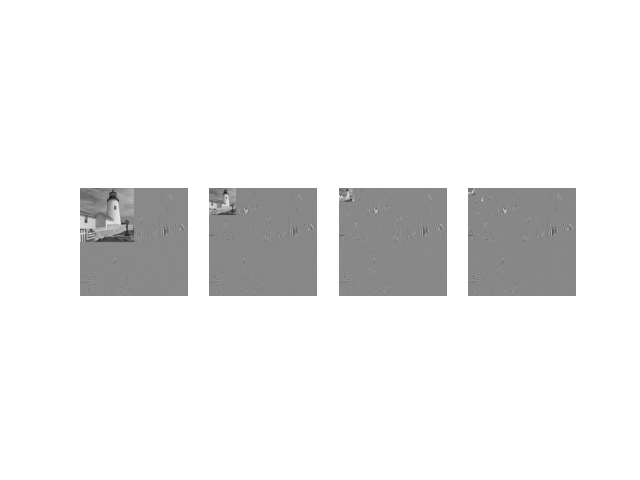

In [16]:
# your code here
fig, axs = plt.subplots(1, 4)
axs = iter(axs)
m = 256
Y = X.copy()
while m > 1:
    Y[:m, :m] = dwt(Y[:m, :m])
    m = m // 2
    try:
        ax = next(axs)
    except StopIteration:
        pass
    else:
        plot_image(Y, ax = ax)
        ax.axis('off')

plt.show()

We now have the image split using a binary wavelet tree (stricly a
quaternary tree in 2-D).  Write
similar iterative code to that given above, which can reconstruct
the image from the final set of `Y` sub-images after a 4-level
wavelet transform. Check that your reconstructed image is the
same as `X`.

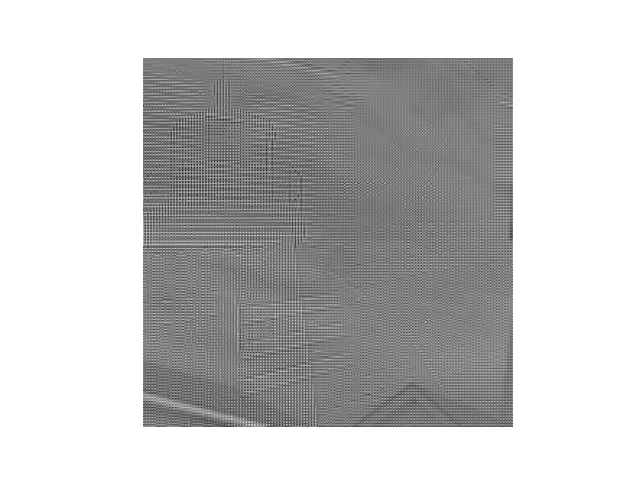

In [17]:
# your code here
fig, ax = plt.subplots()
Xr = Y.copy()
m = 1
while m <= 256:
    m = m * 2
    Xr[:m, :m] = idwt(Xr[:m, :m])
    
plot_image(Xr, ax = ax)
ax.axis('off')

plt.show()

## 9.3 Quantisation and coding efficiency

First rewrite the sequences of operations required to perform
$n$ levels of DWT and inverse DWT as two separate M-files, `nlevdwt` and `nlevidwt`. `nlevdwt` should transform
`X` into `Y`, and `nlevidwt` should inverse
transform a quantised set of sub-images `Yq` into the
reconstructed image `Z`.  Check your functions by ensuring
that `Z` is the same as `X` if `Yq = Y`.

In [18]:
def nlevdwt(X, n):
    # your code here
    m = 256
    Y = dwt(X)
    for i in range(n-1):
        Y[:m, :m] = dwt(Y[:m, :m])
        m = m // 2

    return Y, m
        

def nlevidwt(Y, n, m):
    # your code here
    Z = Y.copy()
    for i in range(n):
        m = m * 2
        Z[:m, :m] = idwt(Z[:m, :m])

    return Z

In [19]:
# your code here to test `nlevdwt` and `nlevidwt`
n = 3
Y3, m3 = nlevdwt(X, n)
Z3 = nlevidwt(Y3, n, m3)
np.testing.assert_equal(Z3, X)

In [20]:
Y3

array([[-5.93695068e+00, -5.20262909e+00, -8.58380127e+00, ...,
        -1.23046875e-01, -1.72656250e+00,  1.40234375e+00],
       [-2.12995300e+01, -1.17310257e+01, -1.59763336e+01, ...,
        -1.91406250e-01,  6.83593750e-02, -1.38671875e-01],
       [-2.72089615e+01, -2.24899864e+01, -1.16425018e+01, ...,
         8.85742188e-01,  6.64062500e-02, -5.46875000e-02],
       ...,
       [ 1.06835938e+00, -1.75781250e-02, -2.05078125e-02, ...,
        -3.32031250e-01,  3.60156250e+00,  4.15625000e+00],
       [ 5.27343750e-01, -8.50585938e-01,  0.00000000e+00, ...,
        -5.27343750e-01, -4.21875000e-01,  3.12500000e-02],
       [ 8.35937500e-01, -1.95312500e+00, -1.73828125e-01, ...,
        -5.00000000e-01, -1.03125000e+00, -2.40625000e+00]])

In [21]:
Y3.shape

(256, 256)

Now design a function, `quantdwt`, which will quantise the
sub-images of `Y` to give `Yq` and calculate their
entropy.  The sub-images at each level `i` of the DWT should
be quantised according to a $3 \times (n+1)$ matrix `dwtstep[k,i]` of
step-sizes, where $\mathtt{k}=\left\{0,1,2\right\}$ corresponds to each of the three high-pass images at level `i` (top right, bottom left, and bottom right, respectively), and the final low-pass image is quantised with `dwtstep[0,n]`. This matrix will be populated either with the same number in all elements (for equal-step-size quantisation) or a range of different numbers (for equal-MSE quantisation). The entropies for each sub-image should be stored in a similar $3 \times (n+1)$ matrix `dwtent[k,i]`.

In [22]:
def quantdwt(Y: np.ndarray, dwtstep: np.ndarray, n) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters:
        Y: the output of `dwt(X, n)`
        dwtstep: an array of shape `(3, n+1)`
    Returns:
        Yq: the quantized version of `Y`
        dwtenc: an array of shape `(3, n+1)` containing the entropies
    """
    # your code here
    dwtent = np.zeros((3, n + 1))
    Yq = Y.copy()
    num_bits = 0

    for i in range(1, n + 1):
        m = 256 // (2 ** (i - 1))
        for k in range(3):
            if k == 0:
                row = slice(0, int(m // 2))
                col = slice(int(m // 2), int(m))
            elif k == 1:
                row = slice(int(m // 2), int(m))
                col = slice(0, int(m // 2))
            elif k == 2:
                row = slice(int(m // 2), int(m))
                col = slice(int(m // 2), int(m))
            Yq[row, col] = quantise(Yq[row, col], dwtstep[k, i])
            dwtent[k, i] = bpp(Yq[row, col])
            num_bits += bpp(Yq[row, col]) * Yq[row, col].size

    # quantise final low-pass
    m = 256 // (2 ** n)
    row = slice(0, m)
    col = slice(0, m)
    Yq[row, col] = quantise(Y[row, col], dwtstep[0, n])
    dwtent[0, n] = bpp(Yq[row, col])
    num_bits += bpp(Yq[row, col]) * Yq[row, col].size

    return Yq, dwtent, num_bits

 Using these functions, for a given number of levels $n$ (typically
between 3 and 5), you should generate `Y`, quantise it to
give `Yq` and reconstruct `Z` from `Yq`.

In [23]:
# your code here
n = 3
Y3, m3 = nlevdwt(X, n)
dwtstep_17 = np.zeros((3, n+1)) + 17
Yq_3, ent_3, num_bits = quantdwt(Y3, dwtstep_17, n)
Z3 = nlevidwt(Yq_3, n, m3)
print(np.max(abs(X - Z3)))
#np.testing.assert_equal(Z3, X)

80.890625


All of our experiments thus far have been performed on only one image. At this stage it is worth starting to experiment with the additional `Bridge` image, as well as Lighthouse. Bridge contains a lot more fine detail and may not lead to the same conclusions regarding performance.

In [93]:
Xb, _ = load_mat_img(img='bridge.mat', img_info='X', cmap_info={'map'})
Xb = Xb - 128.0

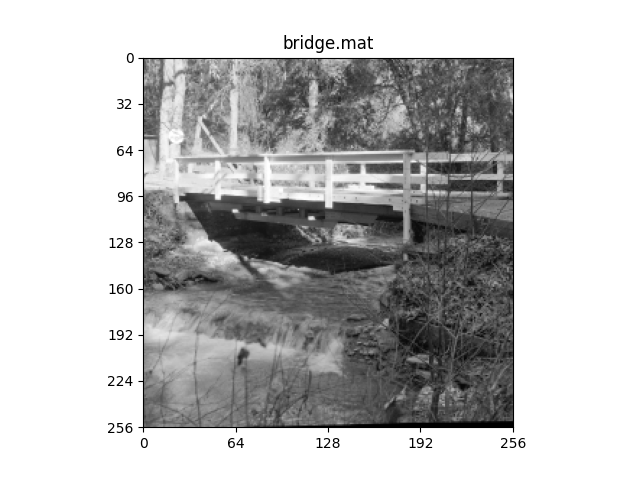

In [25]:
fig, ax = plt.subplots()
plot_image(Xb, ax=ax)
ax.set(title="bridge.mat");


<div class="alert alert-block alert-danger">

Investigate the performance of
both an equal-step-size and an equal-MSE scheme (follow a similar procedure as you used for the Laplacian Pyramid to find the appropriate step-size ratios). Hence determine how many levels of DWT are reasonably optimal for the Lighthouse and Bridge images. Also evaluate the subjective quality of your reconstructed images, and comment on how this depends on $n$ and on the way that step-sizes are assigned
to the different levels. Once again, for each image choose quantisation steps such that you match the rms error to that for direct quantisation with a step-size of 17.</div>

In [27]:
def optimise_equal_step_size(X, n):
    Y, m = nlevdwt(X, n)
    X_q = quantise(X,17)
    rms_direct = np.std(X-X_q)
    rms_list = []
    errs = []
    for i in np.arange(0, 1000)/10:
        Yq, dwtent, bits = quantdwt(Y, np.full((3, n+1), i), n)
        Z = nlevidwt(Yq, n, m)
        rms = np.std(X-Z)
        rms_list.append(rms)
        errs.append(rms - rms_direct) 
    ind_opt = np.argmin(np.abs(errs))
    equal_step_size = ind_opt / 10
    return equal_step_size, rms_list[ind_opt]

In [71]:
def optimise_step_ratio(X, n):
    step_ratios = np.zeros((3, n + 1))
    

    for i in range(1, n + 2):
        mid = X.shape[0] // (2**(i))
        increment = mid // 2
        row_top = slice(0, mid)
        row_bot = slice(mid, mid*2)
        col_left = slice(0, mid)
        col_right = slice(mid, mid*2)
        Xt = np.zeros(shape=(mid * 2, mid * 2))
        Yt, m = nlevdwt(Xt, i)

        if i == n + 1:            
            # Set center of the subimage equal to 100
            Yt[mid, mid] = 100
            Xtr = nlevidwt(Yt, i, m)
            row_top = slice(0, mid)
            col_left = slice(0, mid)

            step_ratios[0, i - 1] = 1 / np.sqrt(np.sum(Xtr[row_top, col_left] ** 2))
        else:
            # Set center of the subimage equal to 100
            i1 = j1 = mid - increment
            i2 = j2 = mid + increment
            Yt[i1, j2] = 100
            Yt[i2, j1] = 100
            Yt[i2, j2] = 100

            # print(mid + (-1)**(2 -  2* abs(k - 2.5)) * (mid // 2), mid + ((-1) ** (k - 1)) * (mid // 2))
            # Yt[int(mid + (-1)**(2 -  2* abs(k - 2.5)) * (mid // 2)), int(mid + ((-1) ** (k - 1)) * (mid // 2))] = 100
            #Yt[mid + (-1)**(k-1)*(mid // 2), mid+(2-2*abs(k-2.5))*(mid // 2)] = 100
            Xtr = nlevidwt(Yt, i, m)
            # print(np.sum(Xtr ** 2))

            step_ratios[0, i - 1] = 1 / np.sqrt(np.sum(Xtr[row_top, col_right] ** 2))  # step size = 1 / sqrt(total energy)
            step_ratios[1, i - 1] = 1 / np.sqrt(np.sum(Xtr[row_bot, col_left] ** 2))
            step_ratios[2, i - 1] = 1 / np.sqrt(np.sum(Xtr[row_bot, col_right] ** 2))

        # print(np.sum(Xtr[row_top, col_left] ** 2))
        # print(np.sum(Xtr[row_top, col_right] ** 2))
        # print(np.sum(Xtr[row_bot, col_left] ** 2))
        # print(np.sum(Xtr[row_bot, col_right] ** 2))

    #step_ratios_mse = (1 / np.min(step_ratios[np.nonzero(step_ratios)])) * step_ratios

    return step_ratios


In [29]:
Xt = np.zeros(shape=(256, 256))
Yt, m = nlevdwt(Xt, 1)
Yt[128, 128] = 100
Xtr = nlevidwt(Yt, 1, m)
print(np.sum(Xtr ** 2))


Xt = np.zeros(shape=(128, 128))
Yt, m = nlevdwt(Xt, 2)
Yt[64, 64] = 100
Xtr = nlevidwt(Yt, 2, m)

print(np.sum(Xtr ** 2))

82656.25
101601.5625


In [84]:
def optimise_mse_step_size(X, step_ratios, n):
    Y, m = nlevdwt(X, n)
    X_q = quantise(X,17)
    rms_direct = np.std(X-X_q)
    rms_list = []
    errs = []
    for i in np.arange(0, 1000):
        Yq, dwtent, bits = quantdwt(Y, i*step_ratios, n)
        Z = nlevidwt(Yq, n, m)
        rms = np.std(X-Z)
        rms_list.append(rms)
        errs.append(rms - rms_direct) 
    ind_opt = np.argmin(np.abs(errs))
    mse_step_size = ind_opt
    return mse_step_size, rms_list[ind_opt], errs[ind_opt]

In [85]:
def find_steps(step_ratios, opt, n):
    step_sizes = np.zeros((3, n + 1))
    for row in range(step_sizes.shape[0]):
        for col in range(step_sizes.shape[1]):
            step_sizes[row, col] = opt * step_ratios[row, col]

    return step_sizes

In [86]:
# Lighthouse image
n = 3
step_l, rms_l = optimise_equal_step_size(X, n)
print(step_l)
dwtstep_l = np.full((3, n+1), step_l)
Yl, ml = nlevdwt(X, n)
Yq_l, ent_3, num_bits_l = quantdwt(Yl, dwtstep_l, n)
Zl_3 = nlevidwt(Yq_l, n, ml)

4.5


In [97]:
Xq = quantise(X, 17)
num_bits_X = bpp(Xq)*X.size
comp3 = num_bits_X/num_bits_l
print(f'compression ratio for lighthouse when n=3: {comp3:.3}')

compression ratio for lighthouse when n=3: 2.59


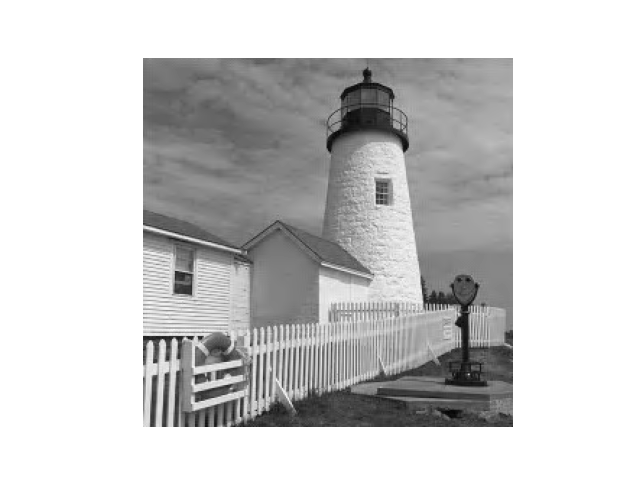

In [34]:
fig, ax = plt.subplots()
ax.imshow(Zl_3, cmap='gray')
plt.axis('off')
#plt.savefig('8_s=14_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

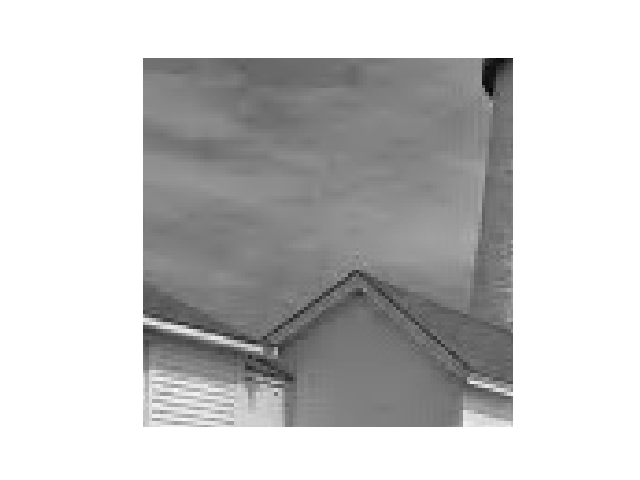

In [35]:
fig, ax = plt.subplots()
ax.imshow(Zl_3, cmap='gray')
plt.axis('off')
ax.set_xlim(35, 135)
ax.set_ylim(155, 55)
#plt.savefig('8_s=14_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

In [88]:
# equal MSE scheme
n = 3
step_ratio_l = optimise_step_ratio(X, n)
mse_l, rms_l, err_l = optimise_mse_step_size(X, step_ratio_l, n)
print(step_ratio_l)
print(mse_l)

[[0.02119252 0.00770051 0.00499179 0.00138678]
 [0.02119252 0.00770051 0.00499179 0.        ]
 [0.00236499 0.0237037  0.01283208 0.        ]]
414


In [98]:
mse_step_size_l = find_steps(step_ratio_l, mse_l, n)
print(mse_step_size_l)
print(err_l)
Yq_l_mse, ent_3, num_bits_l_mse = quantdwt(Yl, mse_step_size_l, n)
Zl_mse_3 = nlevidwt(Yq_l_mse, n, ml)
print(num_bits_X, num_bits_l_mse)
comp3_mse = num_bits_X/num_bits_l_mse
print(f'compression ratio for EMSE lighthouse for n=3: {comp3_mse}')

[[8.77370233 3.18801142 2.06659912 0.57412784]
 [8.77370233 3.18801142 2.06659912 0.        ]
 [0.97910635 9.81333333 5.3124812  0.        ]]
-0.00028552290561556504
228119.03651868744 105387.96469966619
compression ratio for EMSE lighthouse for n=3: 2.1645643994433263


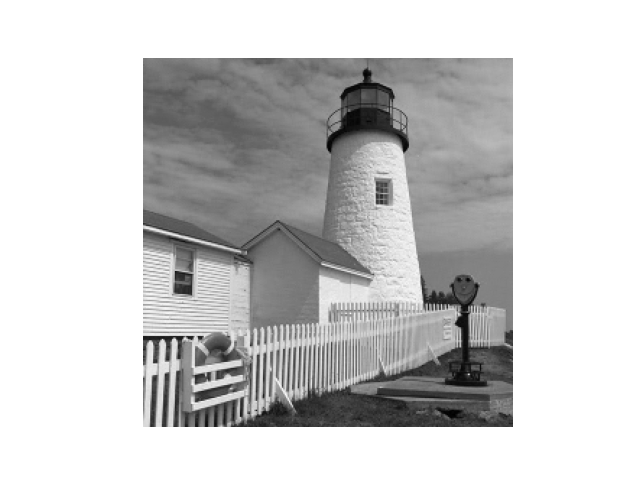

In [54]:
fig, ax = plt.subplots()
ax.imshow(Zl_mse_3, cmap='gray')
plt.axis('off')
#plt.savefig('8_s=14_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

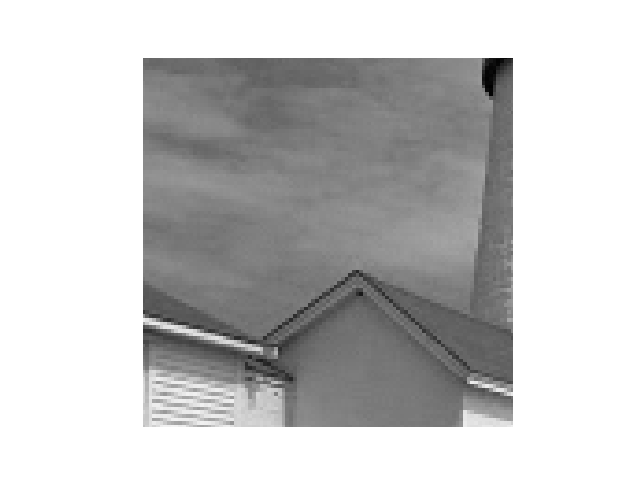

In [55]:
fig, ax = plt.subplots()
ax.imshow(Zl_mse_3, cmap='gray')
plt.axis('off')
ax.set_xlim(35, 135)
ax.set_ylim(155, 55)
#plt.savefig('8_s=14_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

In [90]:
# Bridge image
n = 3
step_b, rms_b = optimise_equal_step_size(Xb, n)
print(step_b)
dwtstep_b = np.full((3, n+1), step_b)
Yb, mb = nlevdwt(Xb, n)
Yq_b, ent_3, num_bits_b = quantdwt(Yb, dwtstep_b, n)
Zb_3 = nlevidwt(Yq_b, n, mb)


3.3


In [99]:
Xq_b = quantise(Xb, 17)
num_bits_Xb = bpp(Xq_b)*Xb.size
comp3_b = num_bits_Xb/num_bits_b
print(num_bits_b)
print(num_bits_Xb)
print(f'compression ratio for bridge when n=3: {comp3_b:.3}')

151697.68769323613
237050.66132911327
compression ratio for bridge when n=3: 1.56


In [95]:
# equal MSE scheme
n = 3
step_ratio_b = optimise_step_ratio(Xb, n)
mse_b, rms_b, err_b = optimise_mse_step_size(Xb, step_ratio_b, n)
print(step_ratio_b)
print(mse_b)

[[0.02119252 0.00770051 0.00499179 0.00138678]
 [0.02119252 0.00770051 0.00499179 0.        ]
 [0.00236499 0.0237037  0.01283208 0.        ]]
248


In [96]:
mse_step_size_b = find_steps(step_ratio_b, mse_b, n)
print(mse_step_size_b)
Yq_b_mse, ent_3, num_bits_b_mse = quantdwt(Yb, mse_step_size_b, n)
Zb_mse_3 = nlevidwt(Yq_b_mse, n, mb)
print(num_bits_X, num_bits_l_mse)
comp3_mse_b = num_bits_X/num_bits_b_mse
print(f'compression ratio for EMSE lighthouse for n=3: {comp3_mse_b}')

[[5.25574439 1.90972665 1.23796276 0.34392199]
 [5.25574439 1.90972665 1.23796276 0.        ]
 [0.58651781 5.87851852 3.18235589 0.        ]]
228119.03651868744 105387.96469966619
compression ratio for EMSE lighthouse for n=3: 1.2490836777955407


## 9.4 Second Interim Report

This report should include the new results from the DCT, LBT and DWT energy
compaction methods in a format that will allow them to be compared with each other and contrasted to the
Laplacian pyramid work in your first report.  Again try to answer questions
raised in the text, and also include discussion of any topics that have led to
unexpected results or have proved particularly interesting.